In [2]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 5.0MB/s 


In [3]:
import os
import numpy as np
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pydicom
import pandas as pd
import torchvision
import torch.utils.data
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import Tensor
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.nn.functional as F
import random
import sys
from tqdm import tqdm
import time
###
from __future__ import print_function, division
import os
import numpy as np
from PIL import Image
import glob
#import SimpleITK as sitk
from torch import optim
import torch.utils.data
import torch
import torch.nn.functional as F

import torch.nn
import torchvision
import matplotlib.pyplot as plt
import natsort
from torch.utils.data.sampler import SubsetRandomSampler
import torchsummary
#from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter

import shutil
import random
import time

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


In [0]:
i= 0 
for file_path in glob.glob("/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm"):
    i=i+1
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    if(i==1):
      break # Comment this out to see all

ValueError: ignored

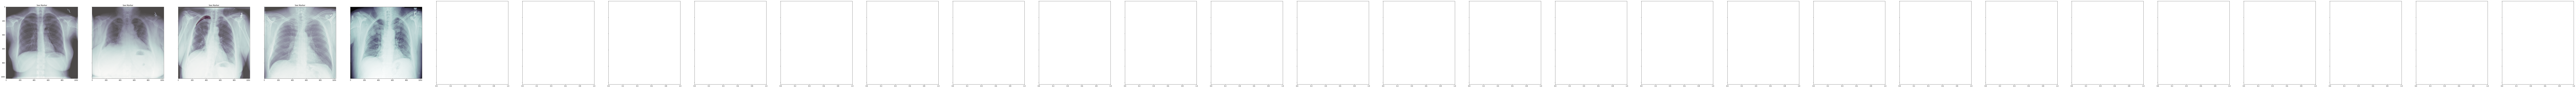

In [6]:
##decoding the mask and specify it in the image
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    current_position = 0
    if(lengths.shape[0]>1):
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height)


# #################################################
#################################################    
start = 1   # Starting index of images
num_img = 30 # Total number of images to show


df = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', header=None, index_col=0)

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for q, file_path in enumerate(glob.glob('/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm')[start:start+num_img]):
    dataset = pydicom.dcmread(file_path)
    #print(file_path.split('/')[-1][:-4])
    ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
        mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
        ax[q].set_title('See Marker')
        ax[q].imshow(mask, alpha=0.3, cmap="Reds")
    else:
        ax[q].set_title('Nothing to see')

In [0]:
def calc_loss(prediction, target, bce_weight=0.5):
    """Calculating the loss and metrics
    Args:
        prediction = predicted image
        target = Targeted image
        metrics = Metrics printed
        bce_weight = 0.5 (default)
    Output:
        loss : dice loss of the epoch """
    bce = F.binary_cross_entropy_with_logits(prediction, target)
    prediction = F.sigmoid(prediction)
    dice = dice_loss(prediction, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss
##########
def dice_loss(prediction, target):
    """Calculating the dice loss
    Args:
        prediction = predicted image
        target = Targeted image
    Output:
        dice_loss"""

    smooth = 1.0

    i_flat = prediction.view(-1)
    t_flat = target.view(-1)

    intersection = (i_flat * t_flat).sum()

    return 1 - ((2. * intersection + smooth) / (i_flat.sum() + t_flat.sum() + smooth))

#########################################

def dice_coeff(im1, im2, empty_score=1.0):
    """Calculates the dice coefficient for the images"""

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im1 = im1 > 0.5
    im2 = im2 > 0.5

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    #print(im_sum)

    return 2. * intersection.sum() / im_sum

In [0]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

###############################
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
####################################
class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=1, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        # d1 = self.active(out)

        return out

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device = torch.device("cuda:0" if train_on_gpu else "cpu")


CUDA is available. Training on GPU


In [10]:
batch_size = 32
print('batch_size = ' + str(batch_size))

valid_size = 0.15

epoch = 15
print('epoch = ' + str(epoch))

random_seed = random.randint(1, 100)
print('random_seed = ' + str(random_seed))

shuffle = True
valid_loss_min = np.Inf
num_workers = 4
lossT = []
lossL = []
lossL.append(np.inf)
lossT.append(np.inf)
epoch_valid = epoch-2
n_iter = 1
i_valid = 0

pin_memory = False
if train_on_gpu:
    pin_memory = True


batch_size = 32
epoch = 15
random_seed = 75


In [11]:
model_Inputs = [U_Net]

def model_unet(model_input, in_channel=1, out_channel=1):
    model_test = model_input(in_channel, out_channel)
    return model_test

#passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary


model_test = model_unet(model_Inputs[0], 1, 1)

model_test.to(device)

U_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [0]:
train_glob = '/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm'
train_fns = sorted(glob.glob(train_glob))[600:700]
df_full = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', index_col='ImageId')

#######################################################
#Passing the Dataset of Images and Labels
#######################################################
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm(enumerate(train_fns), total=len(train_fns)):
    dataset = pydicom.read_file(_id)
    X_train[n] = np.expand_dims(dataset.pixel_array, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test', X_train)
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test', Y_train)

Getting train images and masks ... 


 55%|█████▌    | 55/100 [00:18<00:13,  3.39it/s]

Key 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727 without mask, assuming healthy patient.


100%|██████████| 100/100 [00:34<00:00,  3.20it/s]


Done!


In [13]:
# import numpy as np
# from torch.utils.data import DataLoader, Dataset, TensorDataset
# from torch import Tensor
# ###########################

X_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train.npy')
Y_train = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train.npy')
X_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_valid.npy')
Y_valid = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_valid.npy')
im_height = 128
im_width = 128
X_train = X_train.reshape((-1, im_height, im_width, 1))
Y_train = Y_train.reshape((-1, im_height, im_width, 1))
X_valid = X_valid.reshape((-1, im_height, im_width, 1))
Y_valid = Y_valid.reshape((-1, im_height, im_width, 1))
print(np.shape(X_train))

X_train = np.transpose(X_train, (0,3,2,1))
Y_train =np.transpose(Y_train , (0,3,2,1))
X_valid =np.transpose(X_valid, (0,3,2,1))
Y_valid= np.transpose(Y_valid, (0,3,2,1))
dataset = TensorDataset( Tensor(X_train), Tensor(Y_train) )
dataset2 =  TensorDataset( Tensor(X_valid), Tensor(Y_valid))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=True)
# # Normalizing the whole dataset and finding std and average
# # uncomment lines below to see the average and std for the whole data set
# ############
# train_loader_test = torch.utils.data.DataLoader(Tensor(X_train), batch_size=32, shuffle=True)
# def calculate_img_stats_avg(loader):
#     mean = 0.
#     std = 0.
#     nb_samples = 0.
#     for imgs,_ in loader:
#         batch_samples = imgs.size(0)
#         imgs = imgs.view(batch_samples, imgs.size(1), -1)
#         mean += imgs.mean(2).sum(0)
#         std += imgs.std(2).sum(0)
#         nb_samples += batch_samples

#     mean /= nb_samples
#     std /= nb_samples
#     return mean,std
# print(calculate_img_stats_avg(train_loader_test))
# # #################
initial_lr = 0.001
opt = torch.optim.Adam(model_test.parameters(), lr=initial_lr) # try SGD
#opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

MAX_STEP = int(1e10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, MAX_STEP, eta_min=1e-5)
##########
New_folder = './model'
if os.path.exists(New_folder) and os.path.isdir(New_folder):
    shutil.rmtree(New_folder)

try:
    os.mkdir(New_folder)
except OSError:
    print("Creation of the main directory '%s' failed " % New_folder)
else:
    print("Successfully created the main directory '%s' " % New_folder)



(19200, 128, 128, 1)
Successfully created the main directory './model' 


In [0]:
#######################################################
#Training loop
#######################################################
for i in range(epoch):

    train_loss = 0.0
    valid_loss = 0.0
    since = time.time()
    # scheduler.step(i)
    lr = 10**-3

    #######################################################
    #Training Data
    #######################################################

    model_test.train()
    k = 1

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        #If want to get the input images with their Augmentation - To check the data flowing in net
        #input_images(x, y, i, n_iter, k)

       # grid_img = torchvision.utils.make_grid(x)
        #writer1.add_image('images', grid_img, 0)

       # grid_lab = torchvision.utils.make_grid(y)

        opt.zero_grad()

        y_pred = model_test(x)
        lossT = calc_loss(y_pred, y)     # Dice_loss Used

        train_loss += lossT.item() * x.size(0)
        lossT.backward()
      #  plot_grad_flow(model_test.named_parameters(), n_iter)
        opt.step()
        x_size = lossT.item() * x.size(0)
        k = 2

    #    for name, param in model_test.named_parameters():
    #        name = name.replace('.', '/')
    #        writer1.add_histogram(name, param.data.cpu().numpy(), i + 1)
    #        writer1.add_histogram(name + '/grad', param.grad.data.cpu().numpy(), i + 1)


    #######################################################
    #Validation Step
    #######################################################

    model_test.eval()
    torch.no_grad() #to increase the validation process uses less memory

    for x1, y1 in valid_loader:
        x1, y1 = x1.to(device), y1.to(device)

        y_pred1 = model_test(x1)
        lossL = calc_loss(y_pred1, y1)     # Dice_loss Used

        valid_loss += lossL.item() * x1.size(0)
        x_size1 = lossL.item() * x1.size(0)



    #######################################################
    #To write in Tensorboard
    #######################################################
    (train_idx) = 15
    valid_idx= 15
    train_loss = train_loss / (train_idx)
    valid_loss = valid_loss / (valid_idx)

    if (i+1) % 1 == 0:
        print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(i + 1, epoch, train_loss,
                                                                                      valid_loss))


torch.save(model_test.state_dict(), '/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
U_Net().load_state_dict(torch.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt'))
U_Net().eval()
##########################
X_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test.npy')
Y_test = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test.npy')
X_test = X_test.reshape((-1, im_height, im_width, 1))
Y_test = Y_test.reshape((-1, im_height, im_width, 1))
X_test = np.transpose(X_test, (0,3,2,1))
Y_test = np.transpose(Y_test , (0,3,2,1))
dataset_test = TensorDataset( Tensor(X_test), Tensor(Y_test) )
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

def accuracy(output, target):
    """Computes the accuracy for multiple binary predictions"""
    pred = output >= 0.5
    truth = target >= 0.5
    acc = pred.eq(truth).sum() / target.numel()
    return acc
def dice_score(input, target):
    eps = 1e-8

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return ((2. * intersection + eps) /
            (iflat.sum() + tflat.sum() + eps))
    

########################################
torch.no_grad() #to increase the validation process uses less memory
for x1, y1 in test_loader:
    x1, y1 = x1.to(device), y1.to(device)
    # print(y1.shape)
    # print(y1)
    y_pred1 = model_test(x1)
    lossL = dice_coeff(y1.cpu(), y_pred1.cpu().detach().numpy(), empty_score=1.0)    # Dice_loss Used
    print(lossL)
    
    break

    
 



    #######################################################
    #To write in Tensorboard
    #######################################################

0.0
